In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [7]:


def split_connected_chars(region, gap_threshold=3):
    """Split connected characters using vertical projection gaps"""
    proj = np.sum(region, axis=0) // 255  
    zero_cols = np.where(proj == 0)[0]
    
    # Find gaps of sufficient width
    gaps = []
    if len(zero_cols) > 0:
        start = zero_cols[0]
        end = start
        for i in range(1, len(zero_cols)):
            if zero_cols[i] == zero_cols[i-1] + 1:
                end = zero_cols[i]
            else:
                if end - start + 1 >= gap_threshold:
                    gaps.append((start, end))
                start = zero_cols[i]
                end = start
        if end - start + 1 >= gap_threshold:
            gaps.append((start, end))
    
    # Split at gap midpoints
    split_positions = [(s+e)//2 for s,e in gaps]
    segments = []
    current = 0
    for pos in split_positions:
        segments.append((current, pos))
        current = pos + 1
    segments.append((current, region.shape[1]-1))
    
    return segments


In [8]:

# Load image and preprocess
image = cv2.imread('saved_crops/crop_000.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Shirorekha removal (5px band)
blurred = cv2.GaussianBlur(binary, (5, 5), 0)
hor_proj = np.sum(blurred, axis=1)
peak_row = np.argmax(hor_proj)
binary_nodilation = binary.copy()
binary_nodilation[peak_row-2:peak_row+3, :] = 0  # Remove 5px band

# Dilation to merge text regions
kernel = np.ones((3, 1), np.uint8)
dilated = cv2.dilate(binary_nodilation, kernel, iterations=2)

# Contour detection
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Median width for connected char splitting
widths = [cv2.boundingRect(cnt)[2] for cnt in contours]
median_width = np.median(widths) if widths else 0


In [9]:

# Character bounding box detection
char_bboxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    
    if w > 1.8 * median_width:
        region = binary_nodilation[y:y+h, x:x+w]
        segments = split_connected_chars(region)
        for seg_start, seg_end in segments:
            if np.any(region[:, seg_start:seg_end+1]):
                char_bboxes.append((x + seg_start, y, seg_end - seg_start + 1, h))
    elif w > 5 and h > 10:
        char_bboxes.append((x, y, w, h))

# Sort left-to-right
char_bboxes = sorted(char_bboxes, key=lambda b: b[0])
char_images = []

# For drawing
boxed_image = image.copy()
for x, y, w, h in char_bboxes:
    # Draw bounding box 
    cv2.rectangle(boxed_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Crop char and pad to square
    char = binary[y:y+h, x:x+w]
    size = max(w, h) + 8
    square = np.zeros((size, size), dtype=np.uint8)
    xoff = (size - w) // 2
    yoff = (size - h) // 2
    square[yoff:yoff+h, xoff:xoff+w] = char
    resized = cv2.resize(square, (32, 32), interpolation=cv2.INTER_AREA)
    char_images.append(resized)


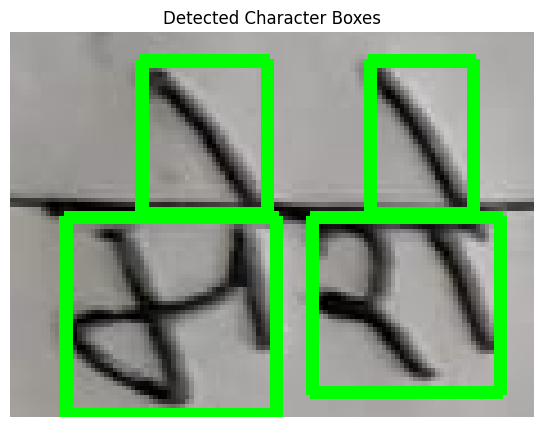

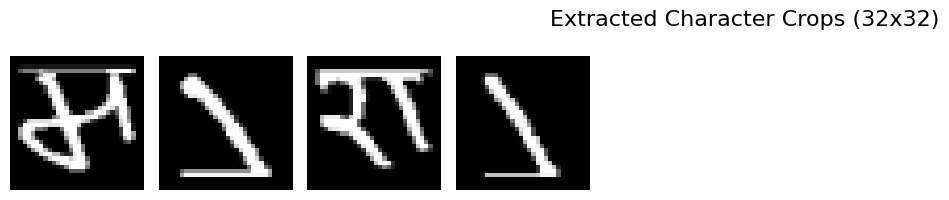

In [10]:


# Show original image with bounding boxes
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(boxed_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Character Boxes")
plt.axis('off')
plt.show()

# Show cropped characters
n = len(char_images)
cols = 10
rows = n // cols + 1

plt.figure(figsize=(15, rows * 2))
for i, char in enumerate(char_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(char, cmap='gray')
    plt.axis('off')
plt.suptitle("Extracted Character Crops (32x32)", fontsize=16)
plt.tight_layout()
plt.show()
